## Constrained Spherical Deconvolution (CSD)

Spherical Deconvolution (SD) is a set of methods to reconstruct the local fiber Orientation Distribution Functions (fODF) from diffusion MRI data. They have become a popular choice for recovering the fiber orientation due to their ability to resolve fiber crossings with small inter-fiber angles in datasets acquired within a clinically feasible scan time. SD methods are based on the assumption that the acquired diffusion signal in each voxel can be modeled as a spherical convolution between the fODF and the fiber response function (FRF) that describes the common signal profile from the white matter (WM) bundles contained in the voxel. Thus, if the FRF can be estimated, the fODF can be recovered as a deconvolution problem by solving a system of linear equations. These methods can work on both single-shell and multi-shell data.

The basic equations of an SD method can summarized as
![spherical_deconvolution_equation](../../../fig/constrained_spherical_deconvolution/spherical_deconvolution_equation.png)

There are a number of variants to the general SD framework that differ, among
others, in the minimization objective and the regularization penalty imposed to
obtain some desirable properties in the linear equation framework.

In order to perform the deconvolution over the sphere, the spherical
representation of the diffusion data has to be obtained. This is done using the
so-called Spherical Harmonics (SH) which are a basis that allow to represent any
function on the sphere (much like the Fourier analysis allows to represent
a function in terms of trigonometric functions).

In this episode we will be using the Constrained Spherical Deconvolution (CSD)
method proposed by Tournier *et al*. in 2007. In essence, CSD imposes a
non-negativity constraint in the reconstructed fODF. For the sake of simplicity,
single-shell data will be used in this episode.

Let's start by loading the necessary data. For simplicity, we will assume that
the gradient table is the same across all voxels after the pre-processing.

In [4]:
import os

import nibabel as nib
import numpy as np

import bids
from bids.layout import BIDSLayout

from dipy.core.gradients import gradient_table
from dipy.data import default_sphere
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti


bids.config.set_option('extension_initial_dot', True)

dwi_layout = BIDSLayout(
    '../../../data/ds000221/derivatives/uncorrected_topup_eddy/', validate=False)
t1_layout = BIDSLayout(
    '../../../data/ds000221/derivatives/uncorrected_topup_eddy_regT1/', validate=False)
gradient_layout = BIDSLayout(
    '../../../data/ds000221/sub-010006/ses-01/dwi/', validate=False)

subj = '010006'

# Get the diffusion files
dwi_fname = dwi_layout.get(subject=subj, suffix='dwi',
                           extension='nii.gz', return_type='file')[0]
bvec_fname = dwi_layout.get(
    subject=subj, extension='eddy_rotated_bvecs', return_type='file')[0]
bval_fname = gradient_layout.get(
    subject=subj, suffix='dwi', extension='bval', return_type='file')[0]


# Get the anatomical file
t1w_fname = t1_layout.get(
    subject=subj, extension='nii.gz', return_type='file')[0]

data, affine = load_nifti(dwi_fname)

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


You can verify the b-values of the dataset by looking at the attribute
``gtab.bvals``. Now that a datasets with multiple gradient directions is
loaded, we can proceed with the two steps of CSD.

## Step 1. Estimation of the fiber response function.

In this episode the response function will be estimated from a local brain region
known to belong to the white matter and where it is known that there are single
coherent fiber populations. This is determined by checking the Fractional
Anisotropy (FA) derived from the DTI model.

For example, if we use an ROI at the center of the brain, we will
find single fibers from the corpus callosum. `DIPY`'s `auto_response` function
will calculate FA for an ROI of radius equal to `roi_radius` in the center
of the volume and return the response function estimated in that region for
the voxels with FA higher than a given threshold.

In [32]:
from dipy.reconst.csdeconv import auto_response

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

# Create the directory to save the results
out_dir = '../../../data/ds000221/derivatives/dwi/reconstruction/sub-%s/ses-01/dwi/' % subj

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Save the FRF
np.savetxt(os.path.join(out_dir, 'frf.txt'),
           np.hstack([response[0], response[1]]))

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: dipy.reconst.csdeconv.auto_response is deprecated, Please use dipy.reconst.csdeconv.auto_response_ssst instead

* deprecated from version: 1.2
* Will raise <class 'dipy.utils.deprecator.ExpiredDeprecationError'> as of version: 1.4
  This is separate from the ipykernel package so we can avoid doing imports until


The `response` tuple contains two elements. The first is an array with
the eigenvalues of the response function and the second is the average `S0`
signal value for this response.

Validating the numerical value of the response function is recommended to ensure
that the FA-based strategy provides a good result. To this end, the elements of
the `response` tuple can be printed and their values be studied.

In [6]:
print(response)

(array([0.00160273, 0.00034256, 0.00034256]), 209.55229)


The tensor generated belonging to the response function must be prolate (two
smaller eigenvalues should be equal), and look anisotropic with a ratio of
second to first eigenvalue of about 0.2. Or in other words, the axial
diffusivity of this tensor should be around 5 times larger than the radial
diffusivity. It is generally accepted that a response function with the
mentioned features is representative of a coherently oriented fiber population.

In [7]:
print(ratio)

0.2137331138364376


It is good practice to visualize the response function's ODF, which also gives
an insightful idea around the SD framework. The response function's ODF should
have sharp lobes, as the anisotropy of its diffusivity indicates:

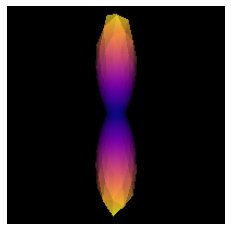

In [33]:
# NBVAL_SKIP

import matplotlib.pyplot as plt
from dipy.sims.voxel import single_tensor_odf
from fury import window, actor

%matplotlib inline

scene = window.Scene()
evals = response[0]
evecs = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T

response_odf = single_tensor_odf(default_sphere.vertices, evals, evecs)
# Transform the data from 1D to 4D
response_odf = response_odf[None, None, None, :]
response_actor = actor.odf_slicer(response_odf, sphere=default_sphere,
                                  colormap='plasma')
scene.add(response_actor)
response_scene_arr = window.snapshot(
    scene, fname=os.path.join(out_dir, 'frf.png'), size=(200, 200),
    offscreen=True)

fig, axes = plt.subplots()
axes.imshow(response_scene_arr, cmap="plasma", origin="lower")
axes.axis("off")
plt.show()

In [9]:
# NBVAL_SKIP

scene.rm(response_actor)

Note that, although fast, the FA threshold might not always be the best way to
find the response function, since it depends on the diffusion tensor, which has
a number of limitations. Similarly, different bundles are known to have
different response functions. More importantly, it also varies across subjects,
and hence it must be computed on a case basis.


## Step 2. fODF reconstruction

After estimating a response function, the fODF is reconstructed through the
deconvolution operation. In order to obtain the spherical representation of the
diffusion signal, the order of the Spherical Harmonics expansion must be
specified. The order, $l$, corresponds to an angular frequency of the basis function. While the series is infinite, it must be truncated to a maximum order in
practice to be able to represent the diffusion signal. The maximum order will
determine the number of SH coefficients used. The number of diffusion encoding
gradient directions must be at least as large as the number of coefficients.
Hence, the maximum order $l_{max}$ is determined by the equation $R = (l_{max}+1)(l_{max}+2)/2$,
where $R$ is the number of coefficients. For example, an order $l_{max} = {4, 6, 8}$ SH
series has $R = {15, 28, 45}$ coefficients, respectively. Note the use of even
orders: even order SH functions allow to reconstruct symmetric spherical
functions. Traditionally, even orders have been used motivated by the fact that
the diffusion process is symmetric around the origin.

The CSD is performed in `DIPY` by calling the `fit` method of the CSD model on
the diffusion data:

In [10]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel

sh_order = 8
csd_model = ConstrainedSphericalDeconvModel(
    gtab, response, sh_order=sh_order, convergence=50)

For illustration purposes we will fit only a small portion of the data representing the splenium of the corpus callosum.

In [11]:
data_small = data[40:80, 40:80, 45:55]
csd_fit = csd_model.fit(data_small)

sh_coeffs = csd_fit.shm_coeff

# Save the SH coefficients
nib.save(nib.Nifti1Image(sh_coeffs.astype(np.float32), affine),
         os.path.join(out_dir, 'sh_coeffs.nii.gz'))

Getting the fODFs from the model fit is straightforward in `DIPY`. As a side
note, it is worthwhile mentioning that the orientation distribution recovered
by SD methods is also named fODFs to distinguish from the diffusion ODFs (dODFs)
that other reconstruction methods recover. The former are considered to be a
sharper version of the latter. At times, they are also called Fiber Orientation
Distribution (FOD).

In [12]:
csd_odf = csd_fit.odf(default_sphere)

We will now use the `generate_anatomical_slice_figure` utility function that allows us to generate three anatomical views (axial superior, sagittal right and coronal anterior) of the data.

Here we visualize only the central slices of the 40x40x10 region (i.e. the `[40:80, 40:80, 45:55]` volume data region) that has been used.

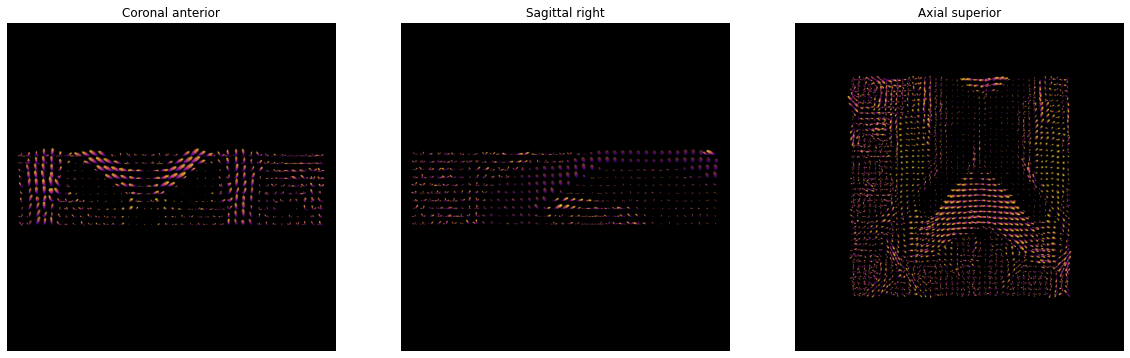

In [28]:
# NBVAL_SKIP

from utils.visualization_utils import generate_anatomical_slice_figure

colormap = "plasma"

# Build the representation of the data
fodf_actor = actor.odf_slicer(
    csd_odf, sphere=default_sphere, scale=0.9, norm=False, colormap=colormap)

# Compute the slices to be shown
slices = tuple(elem // 2 for elem in data_small.shape[:-1])

# Generate the figure
fig = generate_anatomical_slice_figure(slices, fodf_actor, cmap=colormap)

fig.savefig(os.path.join(out_dir, "csd_odfs.png"),
            dpi=300, bbox_inches="tight")
plt.show()

The peak directions (maxima) of the fODFs can be found from the fODFs. For this
purpose, `DIPY` offers the `peaks_from_model` method.

In [14]:
from dipy.direction import peaks_from_model
from dipy.io.peaks import reshape_peaks_for_visualization

csd_peaks = peaks_from_model(model=csd_model,
                             data=data_small,
                             sphere=default_sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

# Save the peaks
nib.save(nib.Nifti1Image(reshape_peaks_for_visualization(csd_peaks),
                         affine), os.path.join(out_dir, 'peaks.nii.gz'))

peak_indices = csd_peaks.peak_indices
nib.save(nib.Nifti1Image(peak_indices, affine),
         os.path.join(out_dir, 'peaks_indices.nii.gz'))

We can visualize them as usual using `fury`:

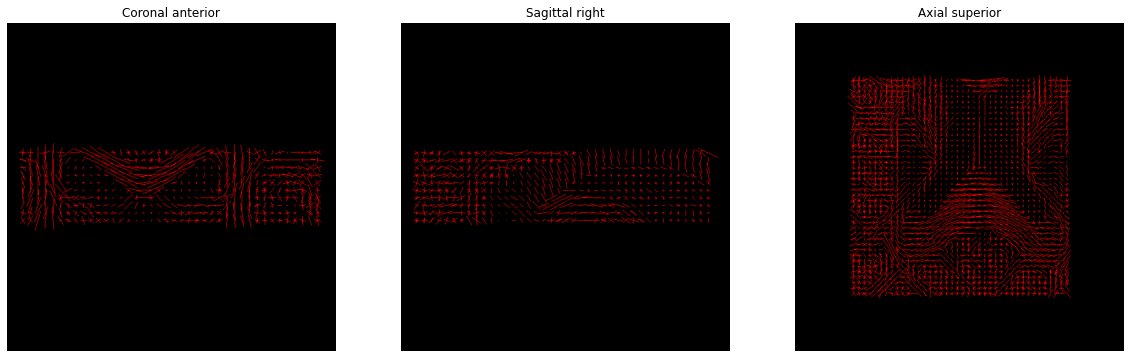

In [29]:
# NBVAL_SKIP

# Build the representation of the data
peaks_actor = actor.peak_slicer(csd_peaks.peak_dirs, csd_peaks.peak_values)

# Generate the figure
fig = generate_anatomical_slice_figure(slices, peaks_actor, cmap=colormap)

fig.savefig(os.path.join(out_dir, "csd_peaks.png"),
            dpi=300, bbox_inches="tight")
plt.show()

We can finally visualize both the fODFs and peaks in the same space.

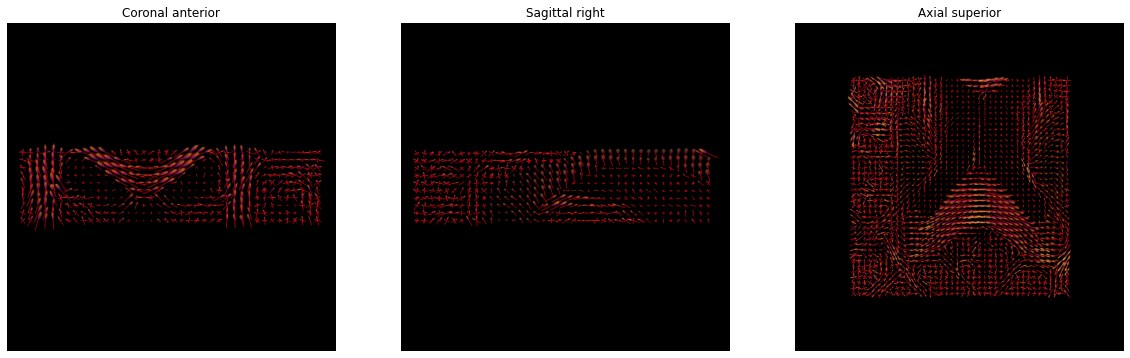

In [34]:
# NBVAL_SKIP

fodf_actor.GetProperty().SetOpacity(0.4)

# Generate the figure
fig = generate_anatomical_slice_figure(
    slices, peaks_actor, fodf_actor, cmap=colormap)

fig.savefig(os.path.join(out_dir, "csd_peaks_fodfs.png"),
            dpi=300, bbox_inches="tight")
plt.show()

References
----------

.. [Tournier2007] J-D. Tournier, F. Calamante and A. Connelly, "Robust
   determination of the fibre orientation distribution in diffusion MRI:
   Non-negativity constrained super-resolved spherical deconvolution",
   Neuroimage, vol. 35, no. 4, pp. 1459-1472, 2007.

## Exercise 1

Simulate the ODF for two fibre populations with crossing angles of 
90, 60, 45, 30, and 20 degrees. We have included helpful hints and 
code below to help you get started.

Helpful hints: 
  * To set the angle between tensors, use `[(0, 0), (angle, 0)]`
  * You may need to use a higher resolution sphere than `default_sphere`
  * You may need to rotate the scene to visualize the ODFs
  * Below is some code to simulate multiple fibre orientations

In [ ]:
from dipy.sims.voxel import multi_tensor_odf

# Eigenvalues for multiple orientations
mevals = np.array(([0.0015, 0.00015, 0.00015], [0.0015, 0.00015, 0.00015]))

# Set fractional value of each tensor
fractions = [50, 50]

## Solution

We will first simulate the ODFs for the different crossing angles:

In [ ]:
import numpy as np

from dipy.data import get_sphere
from dipy.sims.voxel import multi_tensor_odf

# Set eigenvalues for tensors
mevals = np.array(([0.0015, 0.00015, 0.00015], [0.0015, 0.00015, 0.00015]))

# Set fraction for each tensor
fractions = [50, 50]

# Create a list of the crossing angles to be simulated
angles = [90, 60, 45, 30, 20]

odf = []

# Simulate ODFs of different angles
for angle in angles:
    _angles = [(0, 0), (angle, 0)]
    _odf = multi_tensor_odf(get_sphere(
        "repulsion724").vertices, mevals, _angles, fractions)
    odf.append(_odf)

We are now able to visualize and save to disk a screenshot of each ODF crossing. As it can be seen, as the crossing angle becomes smaller, distinguishing the underlying fiber orientations becomes harder: an ODF might be unable to resolve different fiber populations at such crossings, and be only able to indicate a single orientation. This has an impact on tractography, since the tracking procedure will only be able to propagate streamlines according to peaks retrieved by the ODFs. Also, note that this problem is worsened by the presence of noise in real diffusion data.

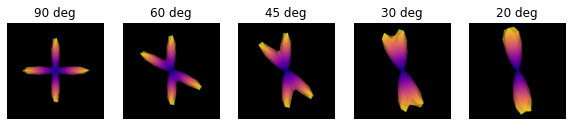

In [ ]:
# NBVAL_SKIP

import matplotlib.pyplot as plt

from fury import window, actor

# Create the output directory to store the image
out_dir = '../../../data/ds000221/derivatives/dwi/reconstruction/exercise/dwi/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

fig, axes = plt.subplots(1, len(angles), figsize=(10, 2))

# Visualize the simulated ODFs of different angles
for ix, (_odf, angle) in enumerate(zip(odf, angles)):
    scene = window.Scene()
    odf_actor = actor.odf_slicer(_odf[None, None, None, :], sphere=get_sphere("repulsion724"),
                                 colormap='plasma')
    odf_actor.RotateX(90)
    scene.add(odf_actor)
    odf_scene_arr = window.snapshot(
        scene, fname=os.path.join(out_dir, 'odf_%d_angle.png' % angle), size=(200, 200),
        offscreen=True)

    axes[ix].imshow(odf_scene_arr, cmap="plasma", origin="lower")
    axes[ix].set_title("%d deg" % angle)
    axes[ix].axis("off")

plt.show()